## Epic 1: Simplest ImpForecast pipeline: 
## Story: Mapping severity level forecasts onto Exposures

This use case uses "full", "continuous" forecast data (1 hazard variable, continuous leadtimes for all ens. members) and simply goes once through the pipeline of mapping hazard, vulnerability & exposure.

### Step 0: Load ensemble-based forecast data

Can be skipped and loaded from sample data in cells below.


Requires the package `meteodata-lab`.

Check out
*  https://github.com/MeteoSwiss/meteodata-lab and 
* https://github.com/MeteoSwiss/opendata-nwp-demos/blob/main/01_retrieve_process_precip.ipynb 

on info and notebooks on how to retrieve MeteoSwiss OGD forecast data.


In [ ]:
import xarray as xr
import numpy as np
import numbers
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


from meteodatalab import ogd_api
from meteodatalab.operators import time_operators as time_ops
from earthkit.data import config

config.set("cache-policy", "temporary")


In [2]:
# Define target lead times ICON2: 5d, here +0h, to +48h
lead_times = [f"P0DT{i}H" for i in np.arange(0, 49)]
model = "ogd-forecasting-icon-ch2"
nwp_vars = ["TOT_PREC", "T_2M", 'VMAX_10M']

In [5]:
dict_ens_data = {}
for var in nwp_vars:
    req = ogd_api.Request(
        collection=model,
        variable=var,
        ref_time="latest",
        perturbed=True,  #ensembles
        lead_time=lead_times,
    )
    dict_ens_data[var] = ogd_api.get_from_ogd(req)

dict_ens_data['TOT_PREC'] = time_ops.delta(dict_ens_data['TOT_PREC'],
                                           np.timedelta64(1, "h"))

In [6]:
# write to file (remove problematic attributes first)
data_path = '/home/muh/data/haz_files/icon/'


def clean_attrs(data_array):
    """
    Recursively cleans all attributes in a DataArray (data, coordinates, and encoding).
    """
    valid_types = (str, numbers.Number, np.ndarray, list, tuple, bytes,
                   type(None), np.integer, np.floating)

    # Clean main data attributes
    data_array.attrs = {
        k: v
        for k, v in data_array.attrs.items() if isinstance(v, valid_types)
    }

    # Clean coordinate attributes
    for coord_name in data_array.coords:
        coord = data_array.coords[coord_name]
        problematic = [
            k for k, v in coord.attrs.items()
            if not isinstance(v, valid_types)
        ]
        for key in problematic:
            print(
                f"Removing coord attr '{coord_name}.{key}': {type(coord.attrs[key])}"
            )
            del coord.attrs[key]

    # Clean encoding
    data_array.encoding = {
        k: v
        for k, v in data_array.encoding.items() if isinstance(v, valid_types)
    }

    return data_array


In [7]:
for var, data in dict_ens_data.items():
    data = clean_attrs(data)
    data.to_netcdf(f"{data_path}icon-ch2-ens-{var.lower()}-latest.nc")

Removing coord attr 'lon.metadata': <class 'earthkit.data.core.metadata.WrappedMetadata'>
Removing coord attr 'lon.parameter': <class 'dict'>
Removing coord attr 'lon.geography': <class 'dict'>
Removing coord attr 'lat.metadata': <class 'earthkit.data.core.metadata.WrappedMetadata'>
Removing coord attr 'lat.parameter': <class 'dict'>
Removing coord attr 'lat.geography': <class 'dict'>
Removing coord attr 'lon.metadata': <class 'earthkit.data.core.metadata.WrappedMetadata'>
Removing coord attr 'lon.parameter': <class 'dict'>
Removing coord attr 'lon.geography': <class 'dict'>
Removing coord attr 'lat.metadata': <class 'earthkit.data.core.metadata.WrappedMetadata'>
Removing coord attr 'lat.parameter': <class 'dict'>
Removing coord attr 'lat.geography': <class 'dict'>
Removing coord attr 'lon.metadata': <class 'earthkit.data.core.metadata.WrappedMetadata'>
Removing coord attr 'lon.parameter': <class 'dict'>
Removing coord attr 'lon.geography': <class 'dict'>
Removing coord attr 'lat.metad

For simple demo: Skip NWP data loading and load "raw EWI severitylevel forecast [1-5] (demo subset for 5 leadtimes x 5 ensemble members)"

In [ ]:

ds_severity = xr.load_dataset('ewi-wind-severitylevels-fordemo.nc')
ds_severity = ds_severity.squeeze()
ds_severity


/tmp/ipykernel_22056/3927944352.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_severity = xr.load_dataset('ewi-wind-severitylevels-fordemo.nc')


<xarray.Dataset> Size: 5MB
Dimensions:                  (lead_time: 5, x: 200, y: 135, realization: 5)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 40B 0 days 00:00:00 ...
  * x                        (x) float32 800B 2.461e+06 2.463e+06 ... 2.859e+06
  * y                        (y) float32 540B 1.051e+06 1.053e+06 ... 1.319e+06
    forecast_reference_time  datetime64[ns] 8B 2023-03-31
  * realization              (realization) int64 40B 0 1 2 3 4
    time                     (lead_time) datetime64[ns] 40B 2023-03-31 ... 20...
Data variables:
    severity                 (lead_time, y, x, realization) float64 5MB nan ....
Attributes:
    crs:      epsg:2056

### Step 1: Workaround: merge ens x lead_time into one dimension

In [69]:
ds_severity_stacked = ds_severity.stack(lead_time_realization=("lead_time",
                                                               "realization"))
# need to reset index because climada hazard.from_xarray cannot handle multiindices
ds_severity_stacked = ds_severity_stacked.reset_index(
    "lead_time_realization", )

# make a convenience coordinate "lead_time_realization_label"
labels = xr.DataArray([
    f"lt_{l}_ens_{r}"
    for l, r in zip(ds_severity_stacked['lead_time'].values,
                    ds_severity_stacked['realization'].values)
],
                      dims="lead_time_realization")

ds_severity_stacked = ds_severity_stacked.assign_coords(
    lead_time_realization_label=labels)

# make a convenience coordinate "frequency" to account for ensembles manually
frequency = 1 / len(np.unique(ds_severity_stacked['realization'].values))
freq_array = xr.DataArray([frequency] *
                          ds_severity_stacked.dims['lead_time_realization'],
                          dims='lead_time_realization')

ds_severity_stacked = ds_severity_stacked.assign_coords(frequency=freq_array)

ds_severity_stacked

/tmp/ipykernel_22056/282254647.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds_severity_stacked.dims['lead_time_realization'],


<xarray.Dataset> Size: 5MB
Dimensions:                      (x: 200, y: 135, lead_time_realization: 25)
Coordinates:
  * x                            (x) float32 800B 2.461e+06 ... 2.859e+06
  * y                            (y) float32 540B 1.051e+06 ... 1.319e+06
    forecast_reference_time      datetime64[ns] 8B 2023-03-31
    time                         (lead_time_realization) datetime64[ns] 200B ...
    lead_time                    (lead_time_realization) timedelta64[ns] 200B ...
    realization                  (lead_time_realization) int64 200B 0 1 ... 3 4
    lead_time_realization_label  (lead_time_realization) <U36 4kB 'lt_0 nanos...
    frequency                    (lead_time_realization) float64 200B 0.2 ......
Dimensions without coordinates: lead_time_realization
Data variables:
    severity                     (y, x, lead_time_realization) float64 5MB na...
Attributes:
    crs:      epsg:2056

### Step 2: load into climada Hazard Object

In [71]:
from climada.hazard import Hazard

haz = Hazard.from_xarray_raster(
    ds_severity_stacked,
    hazard_type='severitylevel',
    intensity_unit=ds_severity_stacked['severity'].attrs['unit'],
    intensity='severity',
    data_vars={
        'event_name': 'lead_time_realization_label',
        'frequency': 'frequency'
    },
    coordinate_vars=dict(longitude="x", latitude="y", event='time'),
    crs=ds_severity_stacked.attrs['crs'])

haz.centroids.to_default_crs()
haz.check()


### Step 3: Load exposures & vulnerability functions

In [54]:
from climada.entity.exposures import Exposures
from climada.entity.exposures.litpop import LitPop

# Population
exp_che = LitPop.from_population(countries=['CHE', 'LIE'], res_arcsec=30)

array([[<Axes: title={'center': 'severitylevel 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
        <Axes: title={'center': 'severitylevel 3: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'severitylevel 4: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
        <Axes: title={'center': 'severitylevel 5: '}, xlabel='Intensity ()', ylabel='Impact (%)'>]],
      dtype=object)

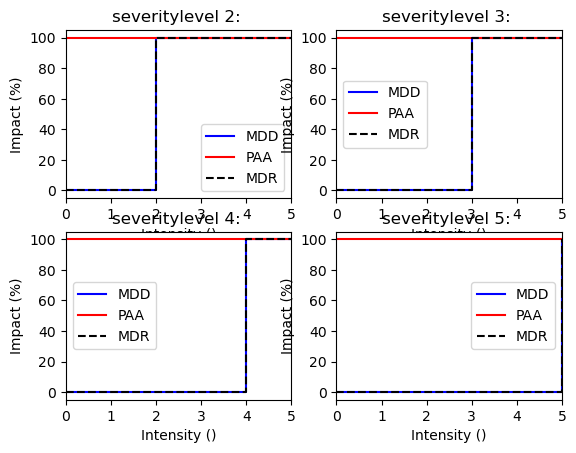

In [ ]:
from climada.entity import ImpactFunc, ImpactFuncSet

# Step functions mapping severity levels 
imp_fun_2 = ImpactFunc.from_step_impf((0, 2, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=2)
imp_fun_3 = ImpactFunc.from_step_impf((0, 3, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=3)
imp_fun_4 = ImpactFunc.from_step_impf((0, 4, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=4)
imp_fun_5 = ImpactFunc.from_step_impf((0, 5, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=5)

impf_set_levels = ImpactFuncSet([imp_fun_2, imp_fun_3, imp_fun_4, imp_fun_5])
impf_set_levels.plot()

### Step 4: Compute impacts on merged Hazard Object

In [73]:
from climada.engine import ImpactCalc

# Impacts population - on "max" hazard (rep. for entire forecast period)
dict_imp_pop = {}

for level in range(2, 6):
    exp_che.gdf[f'impf_{haz.haz_type}'] = level
    dict_imp_pop[level] = ImpactCalc(exp_che, impf_set_levels,
                                     haz).impact(save_mat=True)


### Step 5: Unstack merged ens x leadtime dimension from impact matrix, make new xarray object

In [105]:
dict_imp_reshaped = {}

for level in range(2, 6):
    dense_array = np.asarray(dict_imp_pop[level].imp_mat.todense()
                             )  # shape: (leadtime_ens, coord_exp)

    dense_array = dense_array.reshape(
        (len(np.unique(ds_severity.lead_time)),
         len(np.unique(ds_severity.realization)),
         dense_array.shape[-1]))  # shape: (leadtime, ens, coord_exp)

    # explicitly assign lat lon of exposure to xarray object
    dict_imp_reshaped[level] = xr.DataArray(
        dense_array,
        dims=("lead_time", "realization", "latlon"),
        coords={
            "lead_time": ds_severity.coords["lead_time"],
            "realization": ds_severity.coords["realization"],
            "x": ("latlon", dict_imp_pop[level].coord_exp[:, 0]),
            "y": ("latlon", dict_imp_pop[level].coord_exp[:, 1]),
        },
        name="impact at point")


### Issues 


* in the original impact format, one event is now one leadtime of one ensemble member impact stats per leadtime or per ensemble member are not easily accessible; leadtime and ensemble info can be obtained again by decoding the event name string, but it's cumbersome

<GeoAxes: >

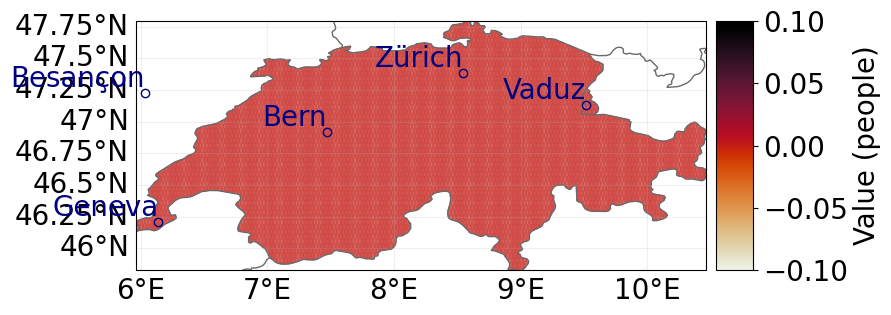

In [ ]:
# for instance, this would be leadtime 0 of ensemble 0

level = 2
dict_imp_pop[level].plot_hexbin_impact_exposure(event_id=haz.event_id[0])


* in the reformatted xarray dataset, stats over leadtime or over ensemble member are easily possible, but we lose the convenience functions of the CLIMADA Impact Object

* we need to do a lot of manual track-keeping on the stacking order of the dimensions, and on correcting the frequency setting (true in either case).

Text(0.5, 1.0, 'Max exposed ppl to warning level (2)')

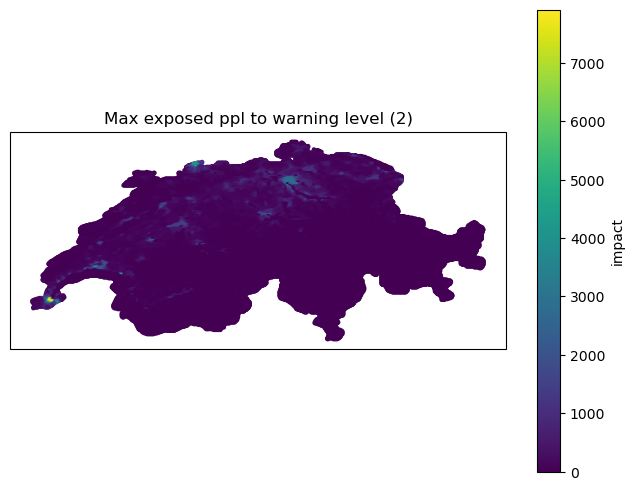

In [ ]:
# example for one realization over all leadtimes

fig, ax = plt.subplots(figsize=(8, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(
    dict_imp_reshaped[level].coords["y"],
    dict_imp_reshaped[level].coords["x"],
    c=dict_imp_reshaped[level].max(dim='lead_time').isel(realization=0),
    cmap="viridis",
    s=5,
    transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="impact")
ax.coastlines()
ax.set_title(f"Max exposed ppl to warning level ({level}) over all leadtimes, for ensemble 0")


In [ ]:
# example for one leadtime over all realizations
fig, ax = plt.subplots(figsize=(8, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(
    dict_imp_reshaped[level].coords["y"],
    dict_imp_reshaped[level].coords["x"],
    c=dict_imp_reshaped[level].max(dim='realization').isel(lead_times=3),
    cmap="viridis",
    s=5,
    transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="impact")
ax.coastlines()
ax.set_title(f"Max exposed ppl to warning level ({level}) at leadtime 3, over all ensembles")